# Section 1

In this notebook, we prepare plots for Section 1 of the manuscript.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from NegativeClassOptimization import utils, preprocessing, ml, config, datasets


/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
base_p = Path(config.DATA_BASE_PATH) / "Frozen_MiniAbsolut_ML"

## df below is loaded based on the experiment ids, from mlflow.
## We can actually load it from file now, since we saved it.
## We also need a script to compute it from scratch, based on SWA for example.
## This will be added later, after dealing with the open set performances, where
## we need to compute the results from scratch anyway.
experiment_ids = ["11", "13", "14"]
df = utils.MLFlowTaskAPI.mlflow_results_as_dataframe(
    experiment_ids, run_name="dev-v0.1.2-3-with-replicates-linear", classify_tasks=True
)
print(df.columns)
# df.to_csv(base_p / "df_task_data.tsv", sep='\t', index=False, )

## To load from file, uncomment the following line
## TODO: errors, need to fix
# df_r = pd.read_csv(base_p / "df_task_data.tsv", sep='\t', index_col=False)


Index(['model_type', 'sample_train', 'load_from_miniabsolut_split_seed',
       'optimizer_type', 'ag_neg', 'batch_size', 'epochs', 'num_hidden_units',
       'N_closed', 'N_train', 'split_id', 'ag_pos', 'swa',
       'shuffle_antigen_labels', 'input_dim', 'learning_rate', 'weight_decay',
       'momentum', 'seed_id', 'load_from_miniabsolut', 'acc_closed',
       'train_loss', 'roc_auc_closed', 'f1_closed', 'avg_precision_closed',
       'precision_closed', 'test_loss', 'recall_closed',
       'mlflow.source.git.commit', 'mlflow.note.content', 'mlflow.source.type',
       'mlflow.runName', 'mlflow.source.name', 'mlflow.log-model.history',
       'mlflow.user', 'experiment', 'run_id', 'task_type', 'split_seed'],
      dtype='object')


In [3]:
df["task_type"].value_counts()

1v1               310
1v9               252
high_vs_95low      90
high_vs_looser     90
Name: task_type, dtype: int64

In [4]:
df[["split_seed", "seed_id"]].value_counts()

split_seed  seed_id
42          0          139
            1          139
            2          139
            3           89
0           0           49
1           0           49
2           0           49
3           0           49
4           0           40
dtype: int64

In [26]:
mask = ((df["task_type"] == "1v9") & (df["ag_pos"].str.contains("_")))
df = df[~mask].copy()

## 1A. Performances across tasks
### 1A1 - 1v1 performances

In [27]:
df_11 = df.loc[df["experiment"] == "11"].copy()
df_11["ags_sorted"] = df_11[["ag_pos", "ag_neg"]].apply(lambda x: "_".join(sorted(x)), axis=1)
df_11["ag_1"] = df_11[["ag_pos", "ag_neg"]].apply(lambda x: sorted(x)[0], axis=1)
df_11["ag_2"] = df_11[["ag_pos", "ag_neg"]].apply(lambda x: sorted(x)[1], axis=1)

Difference between (+,-) and (-,+). Generally below 0.3%. 2 cases of 0.5%. Can be ignored. Difference is of the same order as replicates. Sorting the performance by ag_pos or ag_neg leads to the same order (not shown now).

<AxesSubplot: ylabel='Frequency'>

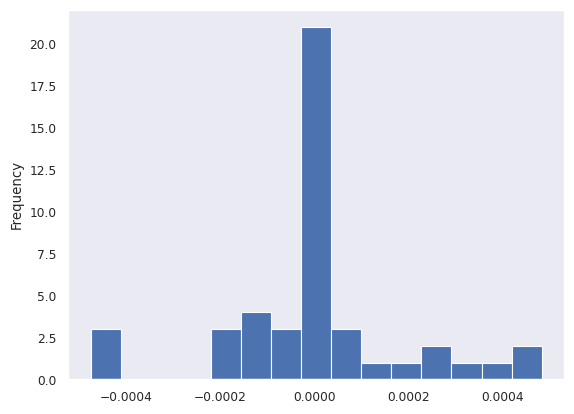

In [28]:
records = []
for ags_sorted in df_11.ags_sorted.unique():
    ag_1 = ags_sorted.split("_")[0]
    ag_2 = ags_sorted.split("_")[1]

    mask_p = (df_11["ag_pos"] == ag_1) & (df_11["ag_neg"] == ag_2)
    mask_n = (df_11["ag_pos"] == ag_2) & (df_11["ag_neg"] == ag_1)

    p_avg = df_11.loc[mask_p]["acc_closed"].mean()
    # p_std = df_11.loc[mask_p]["acc_closed"].std()
    n_avg = df_11.loc[mask_n]["acc_closed"].mean()
    # n_std = df_11.loc[mask_n]["acc_closed"].std()

    records.append({
        "ag_1": ag_1,
        "ag_2": ag_2,
        "ags_sorted": ags_sorted,
        "p_avg": p_avg,
        "n_avg": n_avg,
        "diff": p_avg - n_avg,
    })

df_11_diff = pd.DataFrame(records)
df_11_diff["diff"].plot.hist(bins=15)

When aggregating by ags_sorted, we get low stds (~0.5% is max, but most are around 0.1%), so that, differences of >1% are significant.

In [29]:
df_11.groupby("ags_sorted")["acc_closed"].agg(["mean", "std"]).sort_values("mean", ascending=False)

,mean,std
ags_sorted,,
1H0D_1OB1,0.987183,0.000343
1FBI_3VRL,0.986786,0.000186
1NSN_3VRL,0.985725,0.000089
2YPV_3VRL,0.985671,0.000287
1FBI_1OB1,0.984183,0.000133
1FBI_1NSN,0.977743,0.000583
1H0D_3VRL,0.976900,0.000312
1OB1_2YPV,0.974700,0.000522
1H0D_1WEJ,0.973233,0.000513


<AxesSubplot: xlabel='ag_pos', ylabel='acc_closed'>

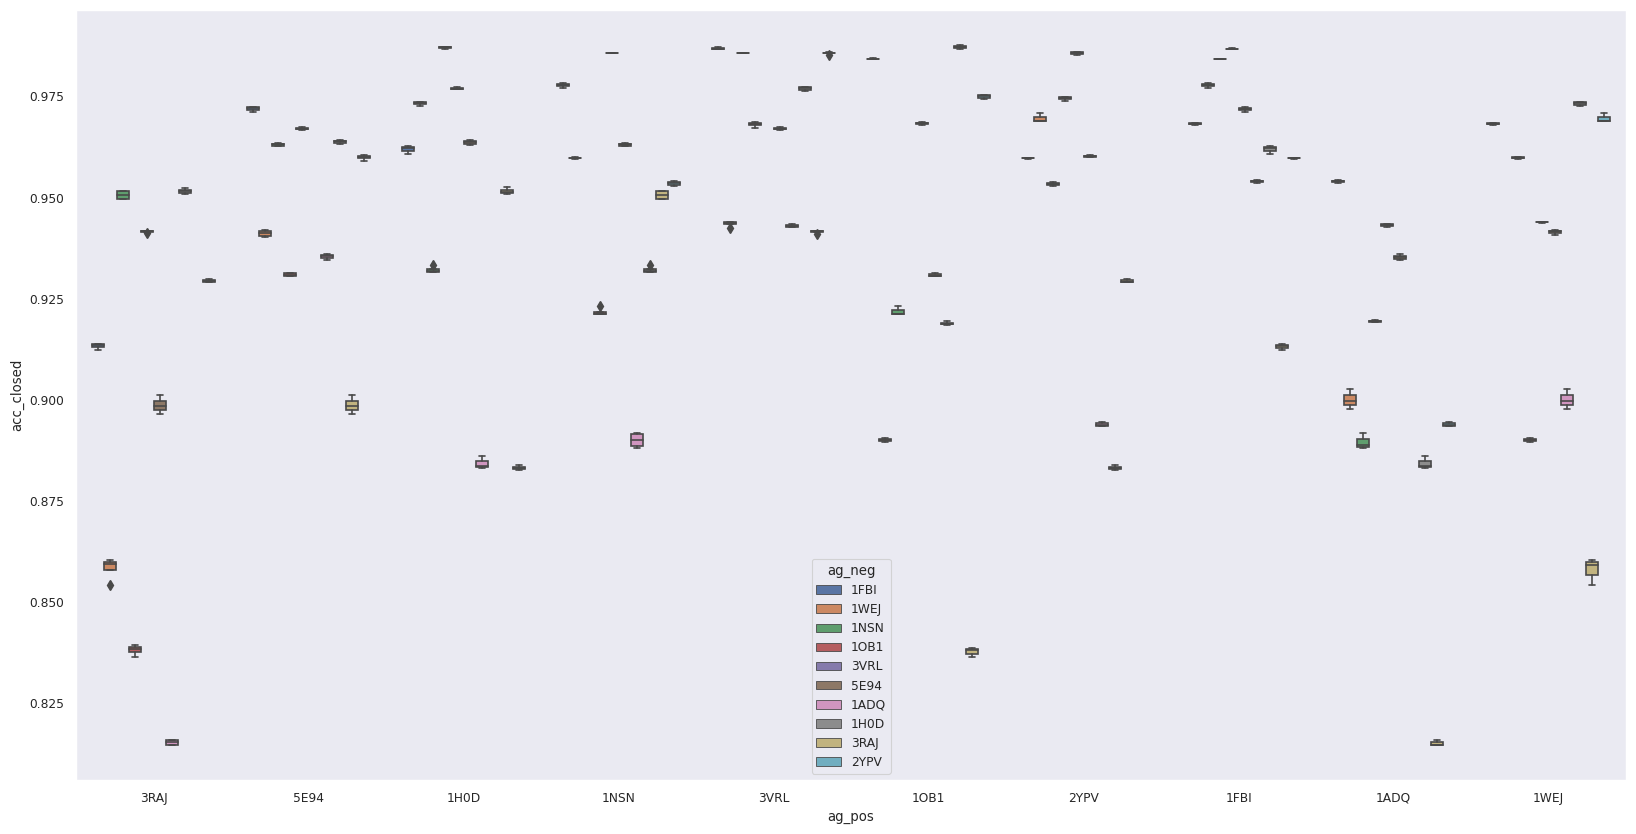

In [30]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(
    x="ag_pos",
    y="acc_closed",
    hue="ag_neg",
    data=df_11,
    ax=ax,
)

<AxesSubplot: xlabel='(acc_closed, mean)', ylabel='(acc_closed, std)'>

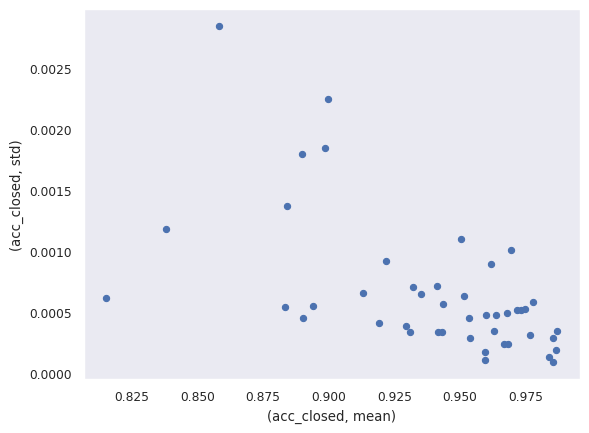

In [31]:
df_11.groupby(["ag_1", "ag_2"]).agg({"acc_closed": ["mean", "std"]}).plot(
    x=("acc_closed", "mean"),
    y=("acc_closed", "std"),
    kind="scatter",
)

In [32]:
df_11_g = df_11.groupby(["ag_1", "ag_2"]).agg("mean")["acc_closed"]

df_11_m = pd.DataFrame(np.zeros((10, 10)), columns=df_11.ag_pos.unique(), index=df_11.ag_pos.unique())
for ag_pos in df_11.ag_pos.unique():
    for ag_neg in df_11.ag_neg.unique():
        if ag_pos == ag_neg:
            continue
        else:
            ag_1 = sorted([ag_pos, ag_neg])[0]
            ag_2 = sorted([ag_pos, ag_neg])[1]
            df_11_m.loc[ag_pos, ag_neg] = df_11_g[ag_1][ag_2]
            df_11_m.loc[ag_neg, ag_pos] = df_11_g[ag_1][ag_2]

/tmp/ipykernel_159879/1146087541.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_11_g = df_11.groupby(["ag_1", "ag_2"]).agg("mean")["acc_closed"]


<AxesSubplot: >

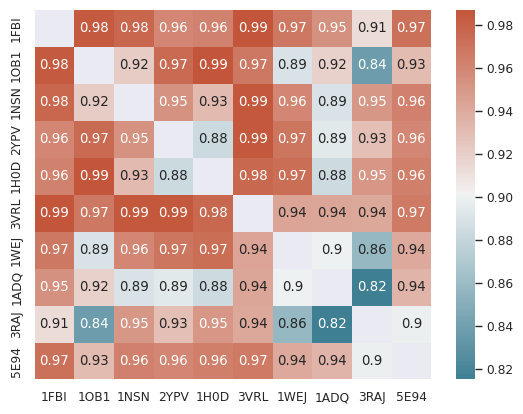

In [33]:
# sns.clustermap(df_11_m, annot=True, cmap="RdBu_r", mask=df_11_m==0)
# g = sns.clustermap(df_11_m, annot=True, cmap="RdBu_r", mask=np.tri(df_11_m.values.shape[0], k=0))

## Doesn't achieve clustermap with mask.
# https://stackoverflow.com/questions/67879908/lower-triangle-mask-with-seaborn-clustermap
# mask = np.tril(np.ones_like(df_11_m))
# values = g.ax_heatmap.collections[0].get_array().reshape(df_11_m.shape)
# new_values = np.ma.array(values, mask=mask)
# g.ax_heatmap.collections[0].set_array(new_values)
# plt.show()

## To get a clustermap with masks, I hardcode the order from the clustermap.
order = ["5E94", "3RAJ", "1ADQ", "1WEJ", "3VRL", "1H0D", "2YPV", "1NSN", "1OB1", "1FBI"]
df_11_m = df_11_m.loc[order[::-1], order[::-1]]
# sns.heatmap(df_11_m, annot=True, cmap="RdBu_r", mask=np.tri(df_11_m.values.shape[0], k=0))
sns.heatmap(
    df_11_m, 
    annot=True, 
    #cmap="RdBu_r",
    cmap=sns.diverging_palette(220, 20, as_cmap=True),
    mask=df_11_m.values == 0
    )


In [34]:
m = df_11_m.values
m = m[m>0]
m.mean(), m.std()

(0.9390498015873017, 0.040666983483154666)

High standard deviations when considering all combinations containing an antigen (stds ~ 1%), but statistically significant differences.

In [35]:
# Statistical test
from itertools import combinations
from scipy.stats import ttest_ind
records = []
for ag_i, ag_j in combinations(df_11.ag_pos.unique(), 2):
    if ag_i == ag_j:
        continue
    mask_i = (df_11["ag_1"] == ag_i) | (df_11["ag_2"] == ag_i)
    mask_j = (df_11["ag_1"] == ag_j) | (df_11["ag_2"] == ag_j)
    t, p = ttest_ind(df_11.loc[mask_i]["acc_closed"], df_11.loc[mask_j]["acc_closed"])
    records.append({
        "ag_i": ag_i,
        "ag_j": ag_j,
        "t": t,
        "p": p,
    })
df_11_stats = pd.DataFrame(records).sort_values("p", ascending=True)
print(df_11_stats.head(10))
print(df_11_stats.tail(10))

# Tabular
records = []
for ag in df_11.ag_pos.unique():
    mask = (df_11["ag_1"] == ag) | (df_11["ag_2"] == ag)
    acc_avg = df_11.loc[mask]["acc_closed"].mean()
    acc_std = df_11.loc[mask]["acc_closed"].std()
    records.append({
        "ag": ag,
        "acc": acc_avg,
        "acc_std": acc_std,
        "acc_range": f'{df_11.loc[mask]["acc_closed"].min()} - {df_11.loc[mask]["acc_closed"].max()}',
        "acc_range_est": f"{acc_avg - 2*acc_std:.3f} - {min(acc_avg + 2*acc_std, 1.0):.3f}",
    })
pd.DataFrame(records).sort_values("acc", ascending=False)

    ag_i  ag_j          t             p
33  3VRL  1ADQ  11.521840  2.776776e-21
3   3RAJ  3VRL -10.339417  1.015592e-18
42  1FBI  1ADQ  10.065749  1.949674e-17
6   3RAJ  1FBI  -9.106885  1.920003e-15
15  5E94  1ADQ   7.712254  3.607504e-12
28  1NSN  1ADQ   7.394855  1.906835e-11
0   3RAJ  5E94  -7.113020  6.472051e-11
2   3RAJ  1NSN  -6.940652  1.589336e-10
22  1H0D  1ADQ   6.377231  3.653813e-09
34  3VRL  1WEJ   6.222876  7.007851e-09
    ag_i  ag_j         t         p
35  1OB1  2YPV -1.676587  0.096364
32  3VRL  1FBI  0.714866  0.476047
26  1NSN  2YPV  0.454411  0.650334
13  5E94  2YPV  0.329776  0.742130
17  1H0D  1NSN -0.273431  0.784966
7   3RAJ  1ADQ -0.196519  0.844528
10  5E94  1NSN -0.185637  0.853014
20  1H0D  2YPV  0.156257  0.876097
9   5E94  1H0D  0.135007  0.892820
38  1OB1  1WEJ  0.037446  0.970195


,ag,acc,acc_std,acc_range,acc_range_est
4,3VRL,0.966590,0.018155,0.941 - 0.9871,0.930 - 1.000
7,1FBI,0.964043,0.021670,0.9123 - 0.9871,0.921 - 1.000
3,1NSN,0.948804,0.027832,0.8881 - 0.9858,0.893 - 1.000
1,5E94,0.947987,0.022936,0.8964 - 0.9724,0.902 - 0.994
2,1H0D,0.947289,0.034959,0.8826 - 0.9877,0.877 - 1.000
6,2YPV,0.946310,0.033528,0.8826 - 0.986,0.879 - 1.000
5,1OB1,0.933505,0.047532,0.8364 - 0.9877,0.838 - 1.000
9,1WEJ,0.933202,0.039364,0.8541 - 0.9737,0.854 - 1.000
8,1ADQ,0.903317,0.040514,0.8147 - 0.9542,0.822 - 0.984
0,3RAJ,0.901742,0.048020,0.8147 - 0.9525,0.806 - 0.998


### 1A2 - looser, 95low and 1v9 performances.

In [36]:
import warnings


# Include 1v1 average performance
warnings.warn("This is not correct, because it's not the same 1v1 as in the other experiments. Need to aggregate over all.")

df_13 = df.loc[df["experiment"].isin(["11", "13", "14"])].copy()
df_13["ag_pos"] = df_13["ag_pos"].apply(lambda x: x.split("_")[0])

# Get order of antigens by high_vs_looser performance
ag_order = df_13.loc[df_13["task_type"] == "high_vs_looser"].groupby("ag_pos")["acc_closed"].mean().sort_values(ascending=False).index.to_list()

/tmp/ipykernel_159879/624294479.py:5: UserWarning: This is not correct, because it's not the same 1v1 as in the other experiments. Need to aggregate over all.
  warnings.warn("This is not correct, because it's not the same 1v1 as in the other experiments. Need to aggregate over all.")


In [37]:
import matplotlib.patheffects as path_effects


def add_median_labels(
    ax,
    fmt=".2f",
    fontsize=6,
    y_offset=0.002,
    x_offset=0.0,
):
    """Add labels to boxplot medians.
    https://stackoverflow.com/questions/38649501/labeling-boxplot-in-seaborn-with-median-value
    """
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == "PathPatch"]
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4 : len(lines) : lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(
            x + x_offset,
            y + y_offset,
            f"{value:{fmt}}",
            ha="center",
            va="center",
            fontweight="bold",
            color="white",
            fontsize=fontsize,
        )
        # create median-colored border around white text for contrast
        text.set_path_effects(
            [
                path_effects.Stroke(linewidth=3, foreground=median.get_color()),
                path_effects.Normal(),
            ]
        )


Text(0.5, 1.0, 'Performance of antigens in different tasks')

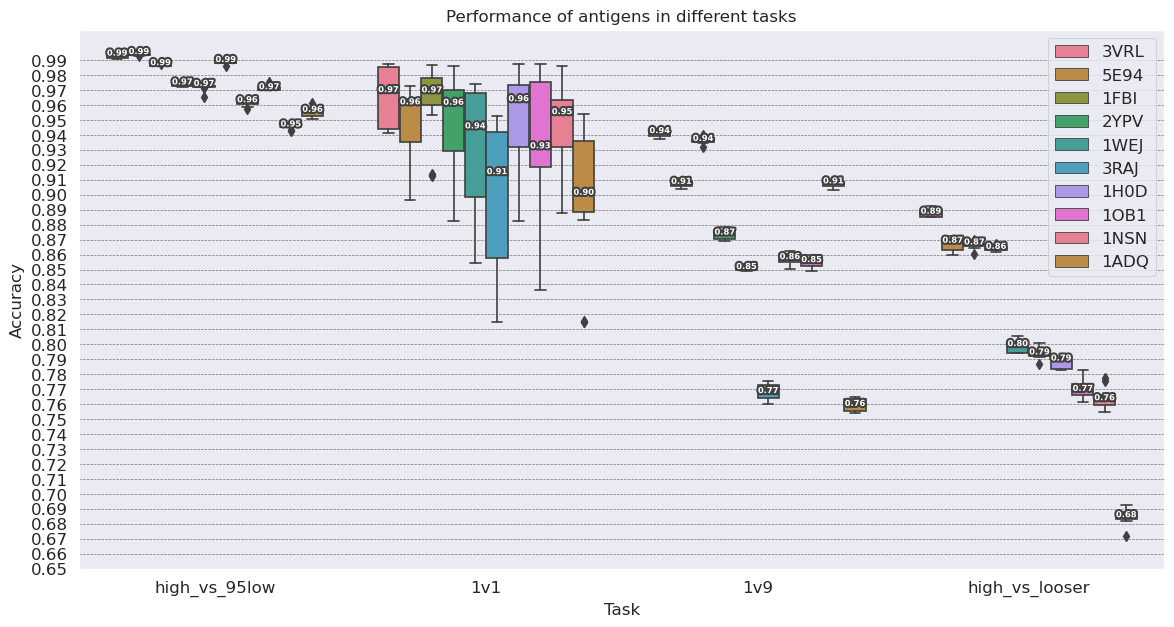

In [38]:
sns.set_theme(context="paper")
sns.set_style("dark")
fig, ax = plt.subplots(figsize=(14, 7))


sns.boxplot(
    x="task_type",
    y="acc_closed",
    hue="ag_pos",
    data=df_13,
    ax=ax,
    # Order on x axis
    order=["high_vs_95low", "1v1", "1v9", "high_vs_looser"],
    hue_order=ag_order,
    # palette="Set2",
    palette=sns.color_palette("husl", 8),
)

add_median_labels(ax)

# Legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Font 20
FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
# Legend font
ax.legend(fontsize=FONT_SIZE)
# Axis labels font FONT_SIZE
ax.set_xlabel("Task", fontsize=FONT_SIZE)
ax.set_ylabel("Accuracy", fontsize=FONT_SIZE)

ax.set_yticks(np.arange(0.65, 1.0, 0.01))
ax.grid(visible=True, axis="y", linestyle="--", linewidth=0.5, color="black", alpha=0.5)

# Title
ax.set_title("Performance of antigens in different tasks", fontsize=FONT_SIZE)

In [39]:
df_13.groupby("task_type")["acc_closed"].agg(["mean", "std"])

,mean,std
task_type,,
1v1,0.939447,0.040484
1v9,0.865332,0.059777
high_vs_95low,0.973861,0.015858
high_vs_looser,0.808280,0.060189


Text(0.5, 1.0, 'Performance of antigens in different tasks')

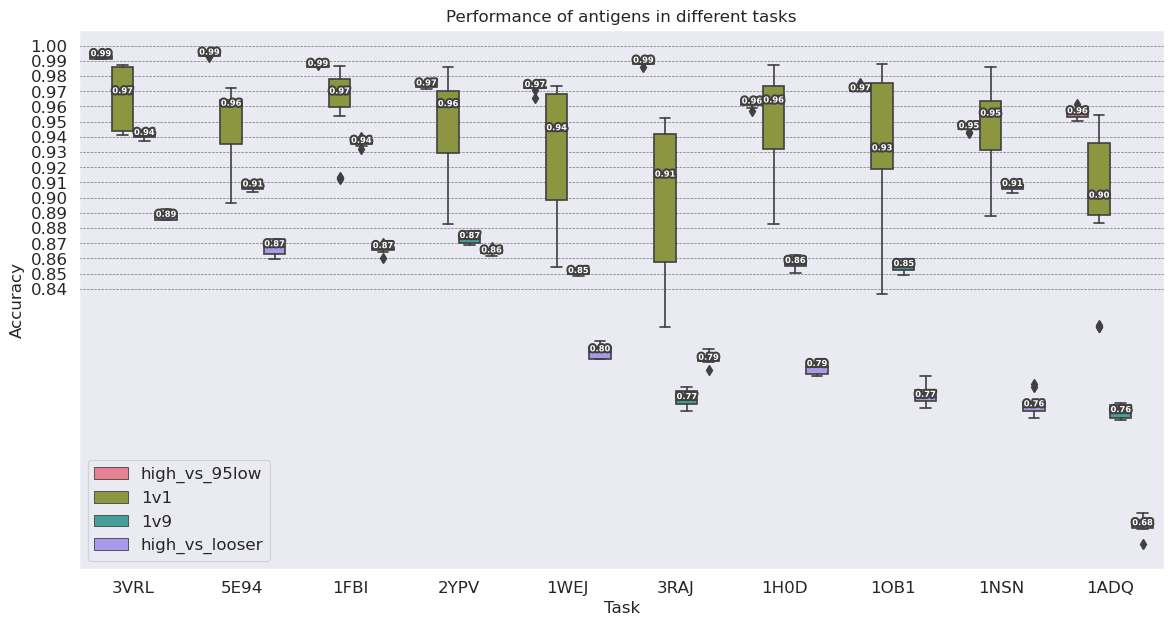

In [40]:
sns.set_theme(context="paper")
sns.set_style("dark")
fig, ax = plt.subplots(figsize=(14, 7))


sns.boxplot(
    x="ag_pos",
    y="acc_closed",
    hue="task_type",
    data=df_13,
    ax=ax,
    order=ag_order,
    hue_order=["high_vs_95low", "1v1", "1v9", "high_vs_looser"],
    # palette="Set2",
    palette=sns.color_palette("husl", 4),
    
)

add_median_labels(ax)

# Legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Font 20
FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
# Legend font
ax.legend(fontsize=FONT_SIZE)
# Axis labels font FONT_SIZE
ax.set_xlabel("Task", fontsize=FONT_SIZE)
ax.set_ylabel("Accuracy", fontsize=FONT_SIZE)

ax.set_yticks(np.arange(0.84, 1.0, 0.01))
ax.grid(visible=True, axis="y", linestyle="--", linewidth=0.5, color="black", alpha=0.5)

# Title
ax.set_title("Performance of antigens in different tasks", fontsize=FONT_SIZE)

In [41]:
df_13.groupby("ag_pos")["acc_closed"].agg(["mean", "std"]).sort_values("mean", ascending=False)

,mean,std
ag_pos,,
3VRL,0.955232,0.034015
1FBI,0.946787,0.042056
5E94,0.936990,0.041038
2YPV,0.924597,0.047968
1NSN,0.915604,0.067274
1H0D,0.910642,0.068146
1WEJ,0.903736,0.066155
1OB1,0.900149,0.076249
3RAJ,0.878360,0.078534


In [42]:
@np.vectorize
def get_ag_order_index(ag, ag_order=ag_order):
    return ag_order.index(ag)

df_13 = df_13.sort_values(["ag_pos"], key=get_ag_order_index)

<AxesSubplot: xlabel='ag_pos', ylabel='acc_closed'>

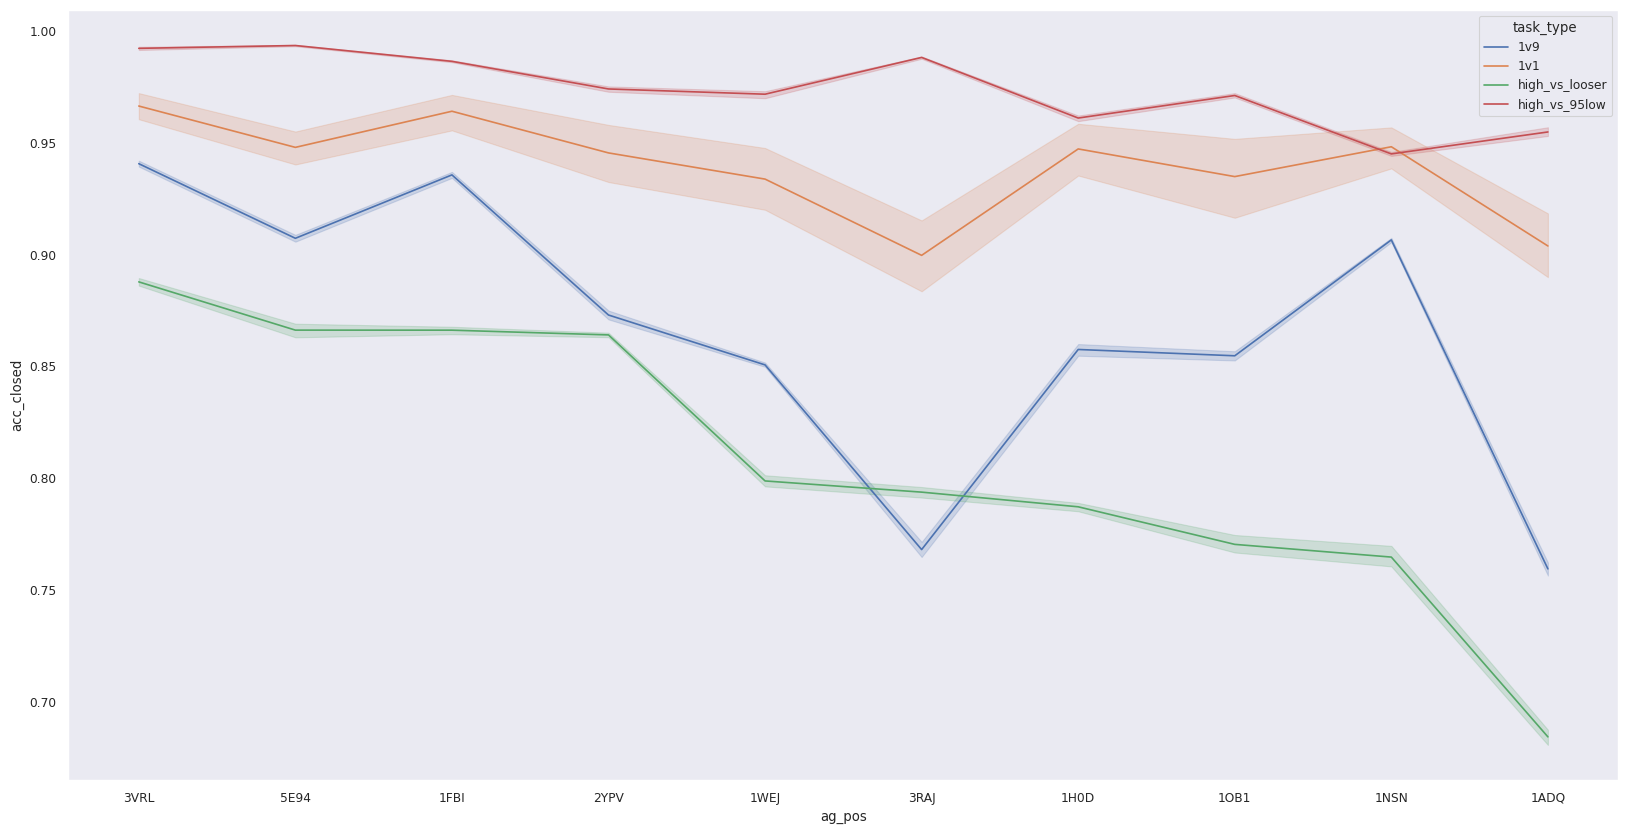

In [43]:
# Seaborn lineplot, x-axis is categorical
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(
    x="ag_pos",
    y="acc_closed",
    hue="task_type",
    data=df_13,
    ax=ax,
)

## 2. Explaining the results.

### 2.1 Normalized Lempel-Ziv Complexity

In [44]:
from NegativeClassOptimization import config

base_p = Path("../data/MiniAbsolut")
slides = {}
for ag in config.ANTIGENS:
    dir_p = base_p / ag
    
    slides_high = pd.read_csv(dir_p / "high_test_5000.tsv", sep='\t')["Slide"].tolist()
    slides[f"{ag}_high"] = slides_high
    
    slides_looser = pd.read_csv(dir_p / "looserX_test_5000.tsv", sep='\t')["Slide"].tolist()
    slides[f"{ag}_looser"] = slides_looser
    
    slides_95low = pd.read_csv(dir_p / "95low_test_5000.tsv", sep='\t')["Slide"].tolist()
    slides[f"{ag}_95low"] = slides_95low

In [45]:
from NegativeClassOptimization import ait


def compute_nlzc(slides, num_shuffles=10):
    lzc = ait.estimate_lzc(num_shuffles, slides)
    N = ait.lzc_numchars(slides)
    nlzc = lzc/N
    return nlzc


records = []
for ag, slides_i in slides.items():
    records.append({
        "ag": ag, 
        "nlzc": compute_nlzc(slides_i),
    })
df_nlzc = pd.DataFrame(records)
df_nlzc

,ag,nlzc
0,3VRL_high,0.190308
1,3VRL_looser,0.199182
2,3VRL_95low,0.202065
3,1NSN_high,0.202160
4,1NSN_looser,0.208655
5,1NSN_95low,0.208197
6,3RAJ_high,0.203742
7,3RAJ_looser,0.206180
8,3RAJ_95low,0.205337
9,5E94_high,0.192878


In [46]:
# df_nlzc["ag_source"] = df_nlzc["ag"].apply(lambda x: x.split("_")[0])
# df_nlzc["ag_aff"] = df_nlzc["ag"].apply(lambda x: x.split("_")[1])


# sns.set_theme(context="paper")
# sns.set_style("dark")
# fig, ax = plt.subplots(figsize=(14, 7))

# sns.barplot(
#     x="ag_source",
#     y="nlzc",
#     hue="ag_aff",
#     data=df_nlzc,
#     order=ag_order,

# )
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# add_median_labels(ax)


# FONT_SIZE = 12
# ax.tick_params(labelsize=FONT_SIZE)
# ax.legend(fontsize=FONT_SIZE)
# # ax.set_xlabel("Task", fontsize=FONT_SIZE)
# # ax.set_ylabel("Accuracy", fontsize=FONT_SIZE)

# ax.set_yticks(np.arange(0, 0.2, 0.01))
# ax.grid(visible=True, axis="y", linestyle="--", linewidth=0.5, color="black", alpha=0.5)

# # Title
# ax.set_title("NLZC", fontsize=FONT_SIZE)

### 2.2 Entropy of slides

In [47]:
from Bio import motifs
from Bio.Seq import Seq
from scipy.stats import entropy


def entropy_slides(slides):

    # Create a list of Seq objects
    seqs = [Seq(slide) for slide in slides]

    # Create a motifs instance
    m = motifs.create(seqs, alphabet=config.AMINOACID_ALPHABET)

    # Get the position weight matrix
    pwm: np.ndarray = pd.DataFrame(m.pwm).values
    pwm += 1e-20  # Avoid log(0)

    # Compute entropy of a position-weight matrix
    return entropy(pwm, axis=1, base=2).sum()
    # return -np.sum(pwm * np.log(pwm), axis=1).sum()  # Same as entropy, checked

entropy_slides(slides["1ADQ_high"])

37.187994400227936

In [48]:
records = []
for ag, slides_i in slides.items():
    records.append({
        "ag": ag, 
        "entropy": entropy_slides(slides_i),
    })
df_entropy = pd.DataFrame(records)
df_entropy

,ag,entropy
0,3VRL_high,30.543936
1,3VRL_looser,34.338510
2,3VRL_95low,35.372931
3,1NSN_high,33.960999
4,1NSN_looser,37.118968
5,1NSN_95low,37.688359
6,3RAJ_high,36.409785
7,3RAJ_looser,37.586293
8,3RAJ_95low,37.083648
9,5E94_high,33.090477


Text(0.5, 1.0, 'Entropy of slides')

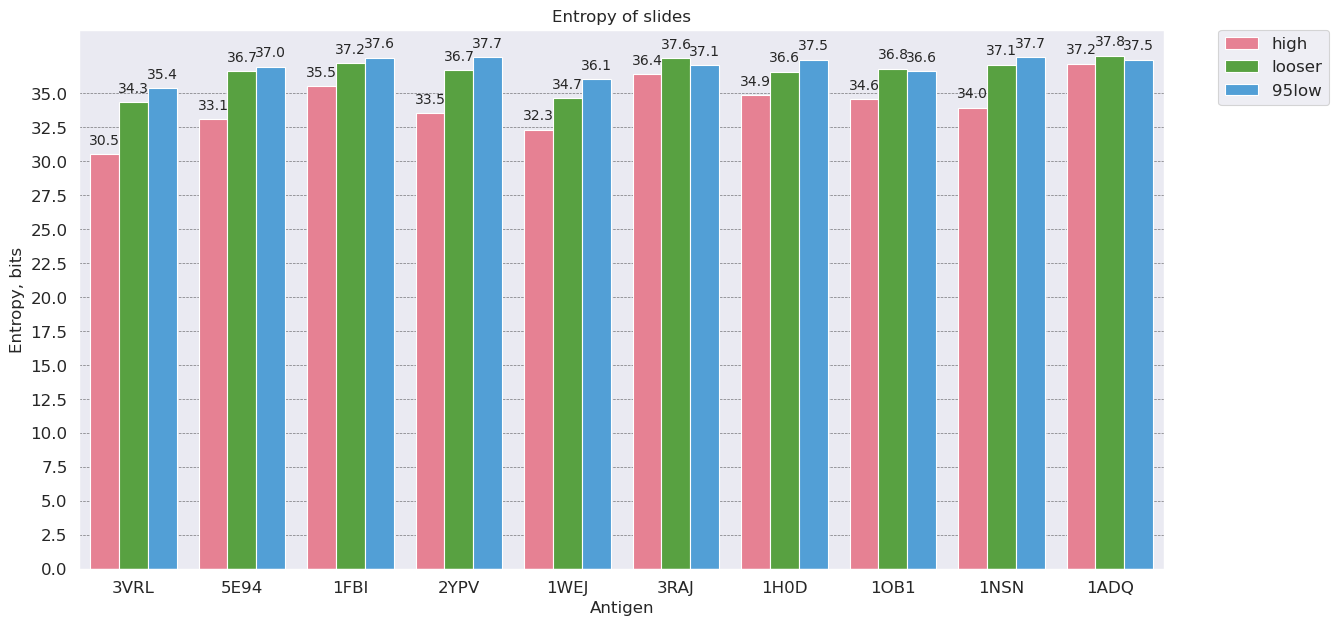

In [49]:
df_entropy["ag_source"] = df_entropy["ag"].apply(lambda x: x.split("_")[0])
df_entropy["ag_aff"] = df_entropy["ag"].apply(lambda x: x.split("_")[1])


sns.set_theme(context="paper")
sns.set_style("dark")
fig, ax = plt.subplots(figsize=(14, 7))

sns.barplot(
    x="ag_source",
    y="entropy",
    hue="ag_aff",
    data=df_entropy,
    order=ag_order,
    palette=sns.color_palette("husl", 3),
    ax=ax
)

# Add text on each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
        fontsize=10,
    )


FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(fontsize=FONT_SIZE, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel("Antigen", fontsize=FONT_SIZE)
ax.set_ylabel("Entropy, bits", fontsize=FONT_SIZE)

ax.set_yticks(np.arange(0, 37, 2.5))
ax.grid(visible=True, axis="y", linestyle="--", linewidth=0.5, color="black", alpha=0.5)

# Title
ax.set_title("Entropy of slides", fontsize=FONT_SIZE)

In [50]:
df_it = pd.merge(df_nlzc, df_entropy, on=["ag", "ag_source", "ag_aff"])
df_it.plot.scatter(x="nlzc", y="entropy")

KeyError: 'ag_source'

### 2.3 Mutual Information

In [ ]:
# Compute Jeffreys Divergence
from Bio import motifs
from Bio.Seq import Seq
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon


def get_pwm(slides_1, slides_2):
    # Create a list of Seq objects
    seqs_1 = [Seq(slide) for slide in slides_1]
    seqs_2 = [Seq(slide) for slide in slides_2]

    # Create a motifs instance
    m_1 = motifs.create(seqs_1, alphabet=config.AMINOACID_ALPHABET) # type: ignore
    m_2 = motifs.create(seqs_2, alphabet=config.AMINOACID_ALPHABET) # type: ignore

    # Get the position weight matrix
    pwm_1: np.ndarray = pd.DataFrame(m_1.pwm).values
    pwm_1 += 1e-20  # Avoid log(0)
    pwm_2: np.ndarray = pd.DataFrame(m_2.pwm).values
    pwm_2 += 1e-20  # Avoid log(0)
    return pwm_1, pwm_2


def jeffrey_divergence_slides(slides_1, slides_2):
    
    pwm_1, pwm_2 = get_pwm(slides_1, slides_2)

    # Compute entropy of a position-weight matrix
    rel_entropy_forward = entropy(pwm_1, pwm_2, axis=1).sum()
    rel_entropy_backward = entropy(pwm_2, pwm_1, axis=1).sum()
    
    # Checked that the following is the same as based on scipy.stats.entropy
    # rel_entropy_forward = np.sum(pwm_1 * np.log(pwm_1 / pwm_2), axis=1).sum()
    # rel_entropy_backward = np.sum(pwm_2 * np.log(pwm_2 / pwm_1), axis=1).sum()
    
    return 1/2 * (rel_entropy_forward + rel_entropy_backward)


def jensen_shannon_divergence_slides(slides_1, slides_2):

    pwm_1, pwm_2 = get_pwm(slides_1, slides_2)
    return jensenshannon(pwm_1, pwm_2, axis=1, base=2).sum()

In [ ]:
L = len(slides)
m = np.zeros((L, L))
df_jsd = pd.DataFrame(m, columns=slides.keys(), index=slides.keys())

for ag_i, slides_i in slides.items():
    for ag_j, slides_j in slides.items():
        if ag_i == ag_j:
            continue
        df_jsd.loc[ag_i, ag_j] = jensen_shannon_divergence_slides(slides_i, slides_j)

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


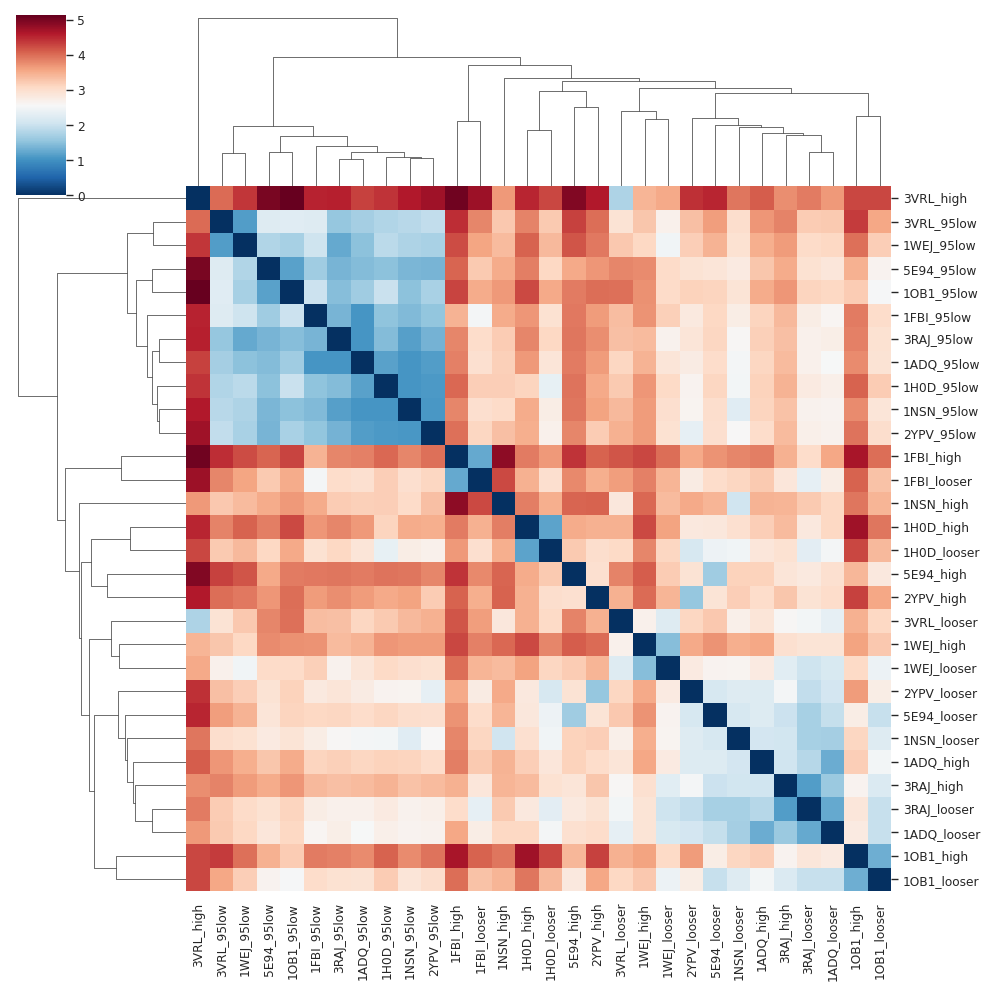

In [ ]:
sns.clustermap(
    df_jsd,
    cmap="RdBu_r",
    xticklabels=True,
    yticklabels=True,
    figsize=(10, 10),
)

In [ ]:
records = []
for ag in config.ANTIGENS:
    h_vs_l = df_jsd.loc[f"{ag}_high", f"{ag}_looser"]
    h_vs_95 = df_jsd.loc[f"{ag}_high", f"{ag}_95low"]
    records.append({
        "ag": ag,
        "h_vs_l": h_vs_l,
        "h_vs_95": h_vs_95,
    })
df_jsd_p = pd.DataFrame(records)

<AxesSubplot: xlabel='ag', ylabel='jsd'>

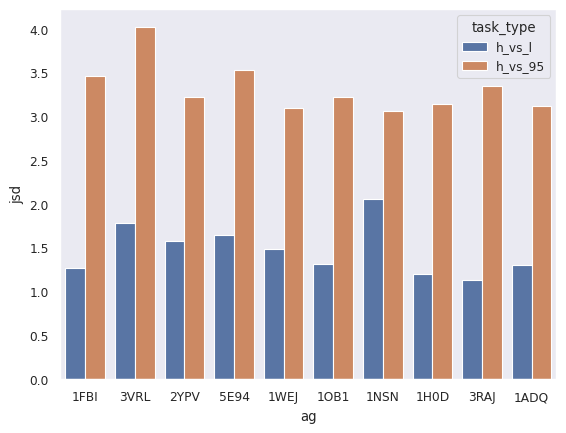

In [ ]:
df_jsd_p = df_jsd_p.melt("ag", value_name="jsd", var_name="task_type")
sns.barplot(
    x="ag",
    y="jsd",
    hue="task_type",
    data=df_jsd_p,
    order=ag_order,
)

In [ ]:
cols = [f"{ag}_high" for ag in config.ANTIGENS]
df_jsd_1v1 = df_jsd.loc[cols, cols].copy()
df_jsd_1v1.columns = [ag.split("_")[0] for ag in df_jsd_1v1.columns]
df_jsd_1v1.index = [ag.split("_")[0] for ag in df_jsd_1v1.index]
df_jsd_1v1

,3VRL,1NSN,3RAJ,5E94,1H0D,1WEJ,1ADQ,1FBI,2YPV,1OB1
3VRL,0.000000,3.688786,3.756918,4.938828,4.529892,3.435892,4.124484,5.067362,4.621037,4.277304
1NSN,3.688786,0.000000,3.449526,4.061132,3.874263,4.053069,3.457256,4.872898,4.082082,3.940220
3RAJ,3.756918,3.449526,0.000000,2.896740,3.390845,2.972713,2.053719,3.476879,3.285022,2.664556
5E94,4.938828,4.061132,2.896740,0.000000,3.528466,4.130747,3.155704,4.415537,2.982723,3.426840
1H0D,4.529892,3.874263,3.390845,3.528466,0.000000,4.273464,3.206473,3.911318,3.478005,4.750259
1WEJ,3.435892,4.053069,2.972713,4.130747,4.273464,0.000000,3.555242,4.290610,4.026073,3.604599
1ADQ,4.124484,3.457256,2.053719,3.155704,3.206473,3.555242,0.000000,3.873643,3.041810,3.209978
1FBI,5.067362,4.872898,3.476879,4.415537,3.911318,4.290610,3.873643,0.000000,4.076355,4.682929
2YPV,4.621037,4.082082,3.285022,2.982723,3.478005,4.026073,3.041810,4.076355,0.000000,4.322922
1OB1,4.277304,3.940220,2.664556,3.426840,4.750259,3.604599,3.209978,4.682929,4.322922,0.000000


<AxesSubplot: >

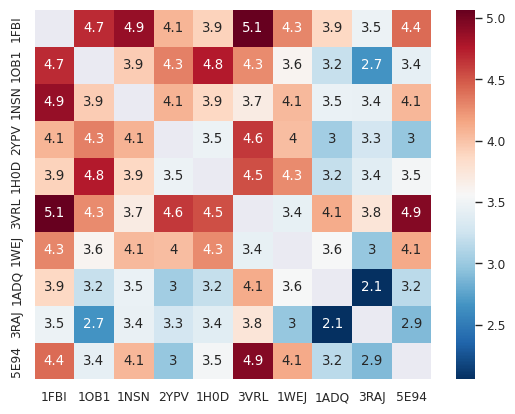

In [ ]:
order = ["5E94", "3RAJ", "1ADQ", "1WEJ", "3VRL", "1H0D", "2YPV", "1NSN", "1OB1", "1FBI"]
df_jsd_1v1 = df_jsd_1v1.loc[order[::-1], order[::-1]]
sns.heatmap(df_jsd_1v1, annot=True, cmap="RdBu_r", mask=df_jsd_1v1.values == 0)

In [ ]:
df_jsd_1v1_melt = df_jsd_1v1.reset_index().melt("index", value_name="jsd", var_name="ag").rename(columns={"index": "ag_1", "ag": "ag_2"})
df_11_m_melt = df_11_m.reset_index().melt("index", value_name="m", var_name="ag").rename(columns={"index": "ag_1", "ag": "ag_2", "m": "accuracy"})

<AxesSubplot: xlabel='jsd', ylabel='accuracy'>

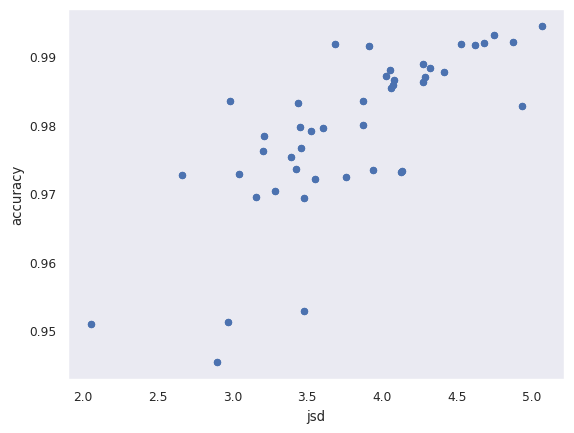

In [ ]:
df_jsd_1v1_merged = pd.merge(df_jsd_1v1_melt, df_11_m_melt, on=["ag_1", "ag_2"])
df_jsd_1v1_merged = df_jsd_1v1_merged.loc[df_jsd_1v1_merged["accuracy"] != 0]
df_jsd_1v1_merged.plot.scatter(x="jsd", y="accuracy")

PearsonRResult(statistic=0.7428033135783498, pvalue=5.2524081203747143e-17)


Text(0.5, 1.0, 'Accuracy vs JSD divergence')

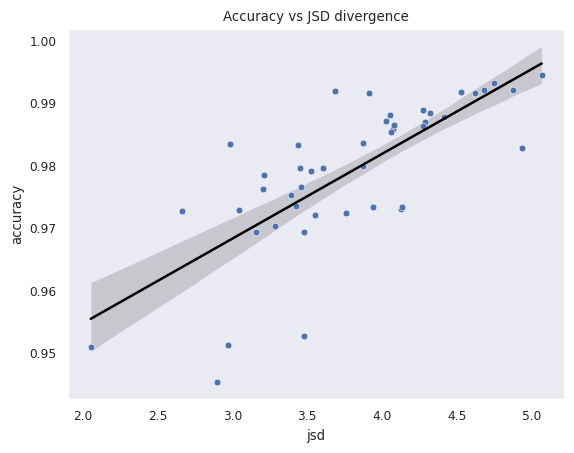

In [ ]:
# Line plot in seaborn with R2 regression
sns.regplot(x="jsd", y="accuracy", data=df_jsd_1v1_merged, scatter=False, color="black")
sns.scatterplot(x="jsd", y="accuracy", data=df_jsd_1v1_merged)

# Compute Pearson correlation
from scipy.stats import pearsonr
print(pearsonr(df_jsd_1v1_merged["jsd"], df_jsd_1v1_merged["accuracy"]))
# Title
plt.title(f"Accuracy vs JSD divergence")

In [ ]:
# Compute JSD for each task
loader = datasets.FrozenMiniAbsolutMLLoader(base_p.parent / "Frozen_MiniAbsolut_ML")
jsds = []
for task_str in df["task"]:
    task = datasets.ClassificationTask.init_from_str(task_str)
    loader.load(task)
    slides_neg = task.test_dataset.query("binds_a_pos_ag == 0")["Slide"].to_list()
    slides_pos = task.test_dataset.query("binds_a_pos_ag == 1")["Slide"].to_list()
    jsd = jensen_shannon_divergence_slides(slides_neg, slides_pos)
    jsds.append(jsd)
df["jsd"] = jsds

1v1
1v9
high_vs_95low
high_vs_looser


Text(0.5, 1.0, 'Accuracy vs JSD divergence')

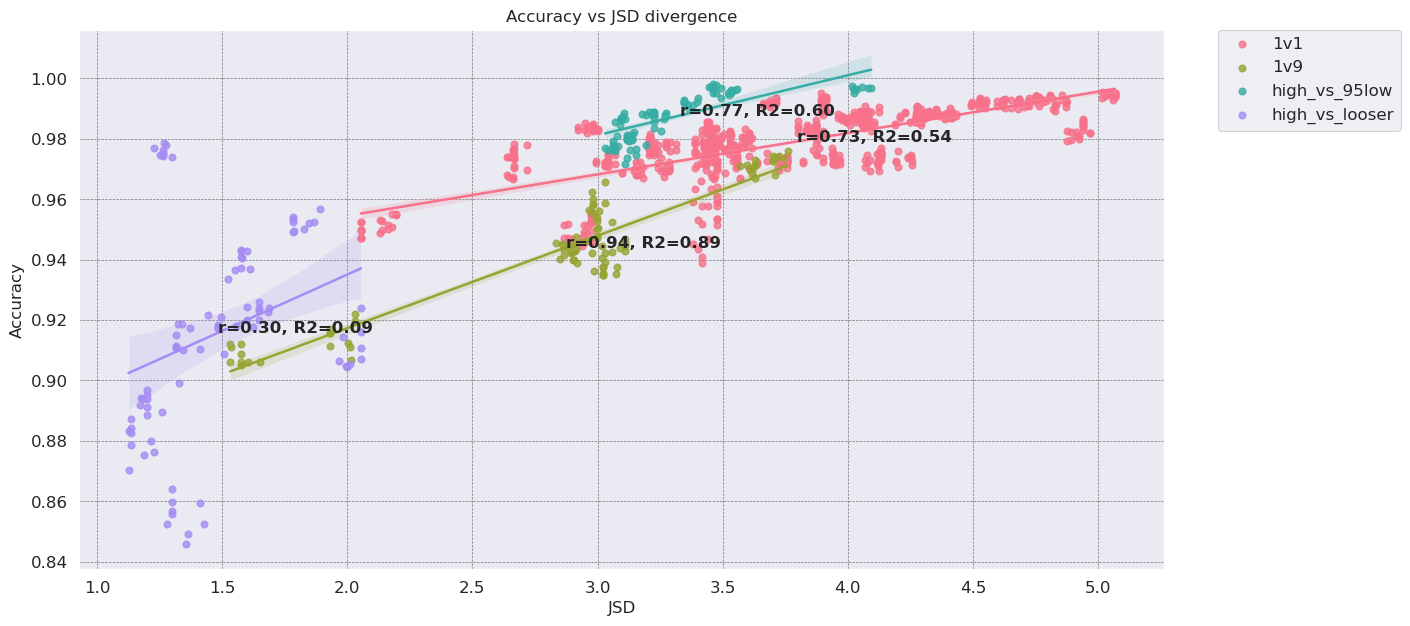

In [ ]:
from scipy.stats import pearsonr


sns.set_theme(context="paper")
sns.set_style("dark")
fig, ax = plt.subplots(figsize=(14, 7))

# Line plot in seaborn with R2 regression
for (i, df_g), color in zip(df.groupby("task_type"), sns.color_palette("husl", 4)):
    print(i)
    sns.regplot(
        x="jsd",
        y="acc_closed",
        data=df_g,
        scatter=True,
        color=color,
        ax=ax,
        label=i,
    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["jsd"], df_g["acc_closed"])
    # Add text with r and R2 at centroid
    x = df_g["jsd"].mean()
    y = df_g["acc_closed"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f}", fontsize=FONT_SIZE, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(fontsize=FONT_SIZE, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
ax.set_xlabel("JSD", fontsize=FONT_SIZE)
ax.set_ylabel("Accuracy", fontsize=FONT_SIZE)

# ax.set_yticks(np.arange(0, 37, 2.5))
ax.grid(visible=True, axis="both", linestyle="--", linewidth=0.5, color="black", alpha=0.5)

# Title
ax.set_title("Accuracy vs JSD divergence", fontsize=FONT_SIZE)


In [ ]:
## Entropy window by energy (based on MiniAbsolut)

# Sorting / inferring binding energy sorting from info theory!

df_high = pd.read_csv("../data/MiniAbsolut/1ADQ/high_test_5000.tsv", sep="\t")
df_looser = pd.read_csv("../data/MiniAbsolut/1ADQ/looserX_test_5000.tsv", sep="\t")
df_ag = pd.concat([df_high, df_looser])
df_ag.sort_values("Energy", inplace=True)

# Apply function on rolling window
window_size = 100
entropies = []
for i in range(0, len(df_ag)):
    ent = entropy_slides(df_ag.iloc[i : i + window_size]["Slide"].to_list())
    entropies.append(ent)
df_ag["Entropy_window"] = entropies

<AxesSubplot: >

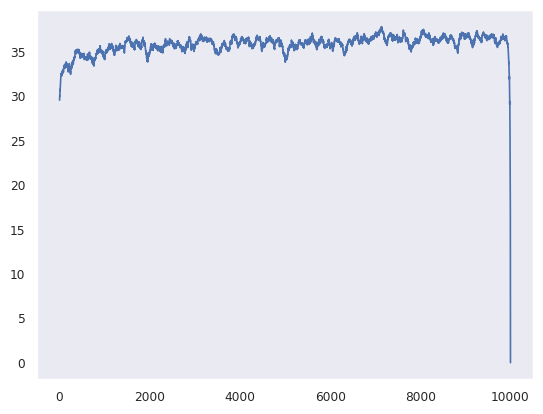

In [ ]:
# df_ag.plot(x="Energy", y="Entropy_window", kind="scatter")
df_ag["Entropy_window"].reset_index(drop=True).plot()

### 2.4 Wasserstein

In [ ]:
# import geomloss

# loss = geomloss.SamplesLoss("sinkhorn", p=2, blur=0.05, scaling=0.9)

# X = torch.rand((5000, 220))
# Y = torch.rand((5000, 220))

# loss(X, Y)

tensor(13.9418)

In [ ]:
# N = 1000

# m = np.zeros((len(config.ANTIGENS), len(config.ANTIGENS)))
# df_w = pd.DataFrame(m, columns=config.ANTIGENS, index=config.ANTIGENS)
# for ag_i in config.ANTIGENS:
#     for ag_j in config.ANTIGENS:

#         if ag_i == ag_j:
#             continue
        
#         if df_w.loc[ag_i, ag_j] != 0 or df_w.loc[ag_j, ag_i] != 0:
#             continue

#         slides_onehot_i = np.stack([preprocessing.onehot_encode(slide) for slide in slides[f"{ag_i}_high"]])
#         slides_onehot_j = np.stack([preprocessing.onehot_encode(slide) for slide in slides[f"{ag_j}_high"]])

#         X = torch.tensor(slides_onehot_i)
#         Y = torch.tensor(slides_onehot_j)

#         # Sample N random sequences from each set
#         X = X[torch.randperm(X.shape[0])[:N]]
#         Y = Y[torch.randperm(Y.shape[0])[:N]]

#         df_w.loc[ag_i, ag_j] = loss(X, Y).item()
#         df_w.loc[ag_j, ag_i] = loss(X, Y).item()

KeyboardInterrupt: 

<AxesSubplot: >

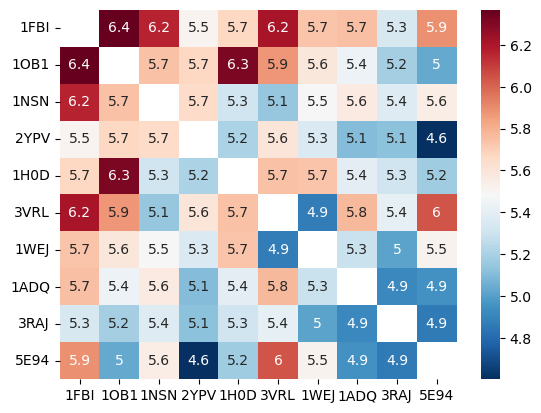

In [ ]:
# order = ["5E94", "3RAJ", "1ADQ", "1WEJ", "3VRL", "1H0D", "2YPV", "1NSN", "1OB1", "1FBI"]
# df_w = df_w.loc[order[::-1], order[::-1]]
# sns.heatmap(df_w, annot=True, cmap="RdBu_r", mask=df_w.values == 0)

In [ ]:
# df_w_melt = df_w.reset_index().melt("index", value_name="wasserstein", var_name="ag").rename(columns={"index": "ag_1", "ag": "ag_2"})
# df_it_merged = pd.merge(df_jsd_1v1_merged, df_w_melt, on=["ag_1", "ag_2"], how="inner")

PearsonRResult(statistic=0.6148600863663587, pvalue=1.1408462939629873e-10)

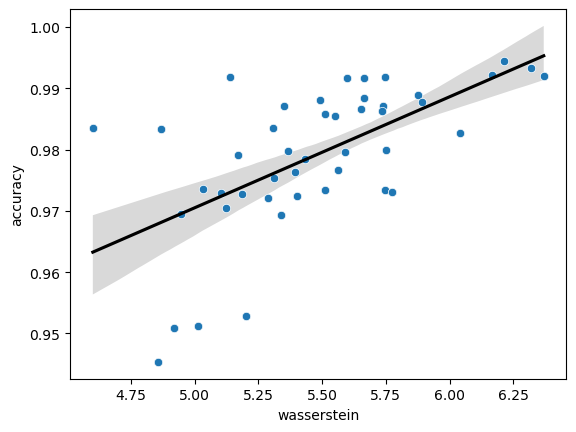

In [ ]:
# # Line plot in seaborn with R2 regression
# sns.regplot(x="wasserstein", y="accuracy", data=df_it_merged, scatter=False, color="black")
# sns.scatterplot(x="wasserstein", y="accuracy", data=df_it_merged)

# # Compute Pearson correlation
# from scipy.stats import pearsonr
# pearsonr(df_it_merged["wasserstein"], df_it_merged["accuracy"])

## 1C. Openset performances.

Precomputation of openset performances (Table 1C) is done in the notebook 15b.

In [ ]:
df_o = pd.read_csv("../data/openset_performance.tsv", sep="\t")
df_o["ag"] = df_o["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).ag_pos)
df_o["task_1_type"] = df_o["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).task_type.to_str())
df_o["task_2_type"] = df_o["task_2"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).task_type.to_str())
def get_replicate_id(task_str):
    task = datasets.ClassificationTask.init_from_str(task_str)
    return str(task.seed_id) + "_" + str(task.split_id)
df_o["replicate_id"] = df_o["task_1"].apply(get_replicate_id)

print(df_o.shape)
df_o.head()

(810, 10)


,task_1,task_2,acc,recall,precision,f1,ag,task_1_type,task_2_type,replicate_id
0,ONE_VS_NINE__3VRL__auto__0__42,ONE_VS_NINE__3VRL__auto__0__42,0.972986,0.975,0.971116,0.973054,3VRL,1v9,1v9,0_42
1,ONE_VS_NINE__3VRL__auto__0__42,HIGH_VS_95LOW__3VRL__auto__0__42,0.987000,0.975,0.998975,0.986842,3VRL,1v9,high_vs_95low,0_42
2,ONE_VS_NINE__3VRL__auto__0__42,HIGH_VS_LOOSER__3VRL__auto__0__42,0.882900,0.975,0.823341,0.892775,3VRL,1v9,high_vs_looser,0_42
3,HIGH_VS_95LOW__3VRL__auto__0__42,ONE_VS_NINE__3VRL__auto__0__42,0.912356,0.998,0.852117,0.919307,3VRL,high_vs_95low,1v9,0_42
4,HIGH_VS_95LOW__3VRL__auto__0__42,HIGH_VS_95LOW__3VRL__auto__0__42,0.996600,0.998,0.995213,0.996605,3VRL,high_vs_95low,high_vs_95low,0_42


In [ ]:
df_o_agg = df_o.groupby(["ag", "task_1_type", "task_2_type"])["acc"].mean().reset_index()
df_o_agg.head()

,ag,task_1_type,task_2_type,acc
0,1ADQ,1v9,1v9,0.914680
1,1ADQ,1v9,high_vs_95low,0.811100
2,1ADQ,1v9,high_vs_looser,0.707333
3,1ADQ,high_vs_95low,1v9,0.693891
4,1ADQ,high_vs_95low,high_vs_95low,0.977011


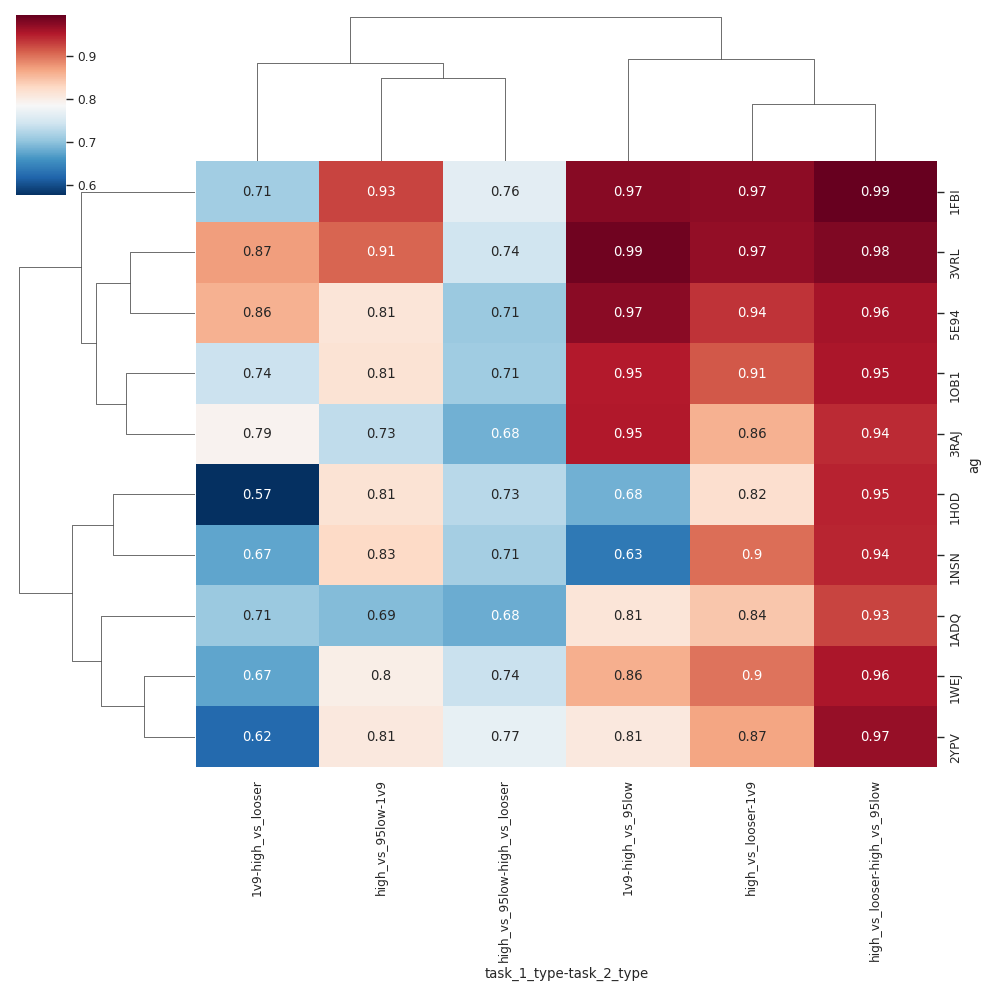

In [ ]:
sns.clustermap(
    df_o_agg.pivot(index="ag", columns=["task_1_type", "task_2_type"], values="acc")
    .drop(axis=1, columns=[("1v9", "1v9"), ("high_vs_looser", "high_vs_looser"), ("high_vs_95low", "high_vs_95low")]),
    cmap="RdBu_r",
    annot=True,
)